In [1]:
import numpy as np
import pandas as pd
import plotnine as pn
from janitor import clean_names
from pyhere import here
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
import joblib
from scipy import stats
import os
from cmdstanpy import CmdStanModel
from great_tables import GT as gt
import plotly.express as px
import plotly.io as pio

jpcolor = 'seagreen'

os.environ['QT_API'] = 'PyQt6'
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True
matplotlib.rcParams.update({'savefig.bbox': 'tight'})
pn.theme_set(pn.theme_light())
pio.templates.default = 'simple_white' # 'plotly_white'

In [2]:
# imported data
contact = pd.read_csv(here('fake_names_emails.csv'))
contact.head()

# correct/incorrect responses to each quiz item
y = pd.read_csv(here('data/quiz/y.csv')).drop(columns = {'Unnamed: 0'})
y['name'] = contact['name']

np.random.seed(12345)
y_sub = y.sample(n = 113)

# q-matrix
q = pd.read_csv(here('data/q_matrix/q.csv')).drop(columns = {'Unnamed: 0'})

# attribute mastery matrix
alpha = pd.DataFrame([(x, y) for x in np.arange(2) for y in np.arange(2)])
alpha = alpha.rename(columns = {0: 'hold1',
                                1: 'hold2'})

# stan dictionary data
irt_dict = {
  'J': y_sub.drop(columns = 'name').shape[0],
  'I': y_sub.drop(columns = 'name').shape[1],
  'Y': np.array(y_sub.drop(columns = 'name'))
}

# Run IRT Model

1.  This will run either a 1pl, 2pl, or 3pl model to assess difficulty of each item, discriminatory power of each item, and guessing respectively.


In [3]:
# irt_file = os.path.join(here('stan_models/irt_1pl.stan'))
irt_file = os.path.join(here('stan_models/irt_2pl.stan'))
# irt_file = os.path.join(here('stan_models/irt_3pl.stan'))

irt_model = CmdStanModel(stan_file = irt_file,
                         cpp_options = {'STAN_THREADS': 'TRUE'})

In [4]:
#running bayesian IRT model
np.random.seed(12345)
irt_fit = irt_model.sample(data = irt_dict,
                        show_console = True,
                        chains = 4,
                        # adapt_delta = .95,
                        iter_warmup = 2000,
                        iter_sampling = 2000)

irt_diagnose = pd.DataFrame(irt_fit.summary())

12:16:57 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 2000
num_warmup = 2000
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /var/folders/dk/cmy022cd5r76h3m6psgj_yf40000gn/T/tmprvffux6d/td7rv8bo.json
init = 2 (Default)
random
seed = 43168
output
file = /var/folders/dk/cmy022cd5r76h3m6psgj_yf40000gn/T/tmprvffux6d/irt_2pleu1nyvus/irt_2pl-20260125121657.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = 8 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 4 (Default)


Gradient evalua

12:17:03 - cmdstanpy - INFO - CmdStan done processing


Chain [4] Iteration: 4000 / 4000 [100%]  (Sampling)

Elapsed Time: 1.631 seconds (Warm-up)
3.715 seconds (Sampling)
5.346 seconds (Total)

Chain [2] Iteration: 4000 / 4000 [100%]  (Sampling)

Elapsed Time: 1.591 seconds (Warm-up)
3.778 seconds (Sampling)
5.369 seconds (Total)

Chain [3] Iteration: 3900 / 4000 [ 97%]  (Sampling)
Chain [3] Iteration: 4000 / 4000 [100%]  (Sampling)

Elapsed Time: 1.761 seconds (Warm-up)
3.761 seconds (Sampling)
5.522 seconds (Total)




In [5]:
irt_diagnose['R_hat'].sort_values(ascending = False).head()

theta[38]    1.00355
theta[69]    1.00285
theta[11]    1.00263
theta[30]    1.00230
theta[99]    1.00227
Name: R_hat, dtype: float64

In [9]:
iirt = az.from_cmdstanpy(
    posterior = irt_fit,
    posterior_predictive = ['y_rep'],
    observed_data = {'Y': y.drop(columns = 'name')})

name_mapping = {'y_rep': 'Y'}
iirt = iirt.rename(name_dict = name_mapping, groups = ["posterior_predictive"])

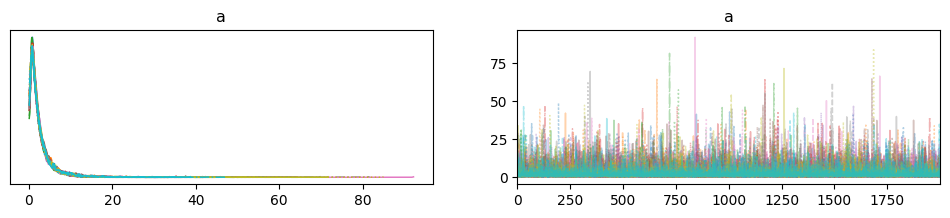

<Figure size 640x480 with 0 Axes>

In [10]:
az.plot_trace(iirt,
              var_names = ('^a'),
              filter_vars = 'regex'
)
plt.show()
plt.clf()

array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

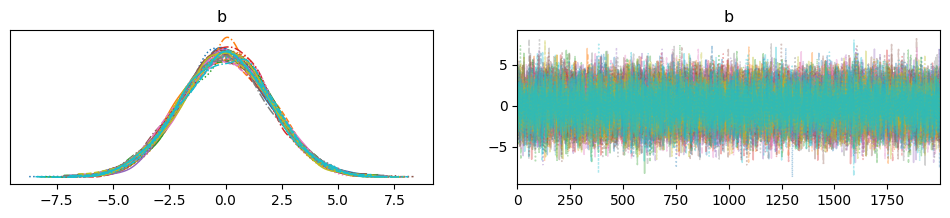

In [ ]:
az.plot_trace(iirt,
              var_names = ('^b'),
              filter_vars = 'regex'
)
plt.show()
plt.clf()

array([[<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>]],
      dtype=object)

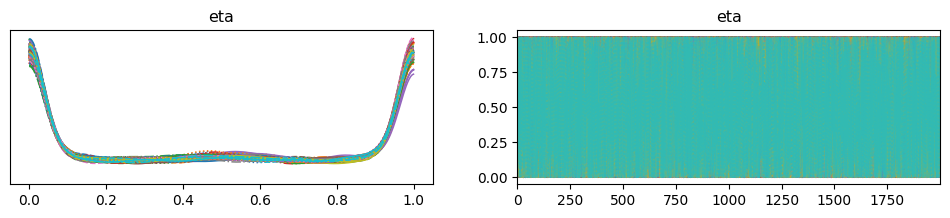

In [ ]:
az.plot_trace(iirt.posterior["eta"].isel(eta_dim_0 = slice(0, 4),
                                          eta_dim_1 = slice(None)
                                          ),
               var_names = 'eta')
plt.show()
plt.clf()

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

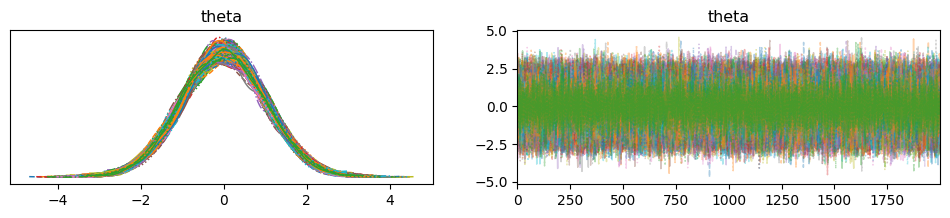

In [ ]:
az.plot_trace(iirt,
              var_names = ('^theta'),
              filter_vars = 'regex'
)
plt.show()
plt.clf()

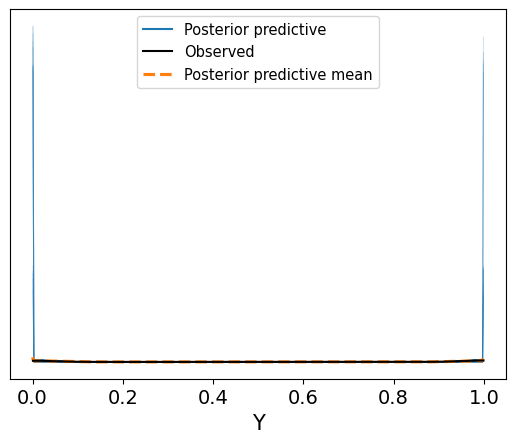

<Figure size 640x480 with 0 Axes>

In [ ]:
az.plot_ppc(iirt,
            data_pairs = {'Y': 'Y'},
            num_pp_samples = 1000)
plt.show()
plt.clf()

/Users/jp/Documents/github_projects/CDSS/data89_evaluation/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


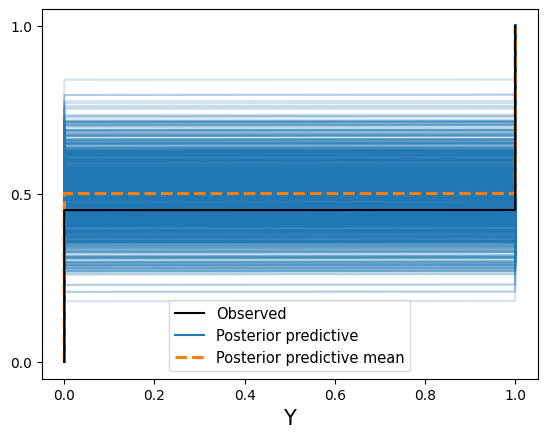

<Figure size 640x480 with 0 Axes>

In [ ]:
az.plot_ppc(iirt,
            data_pairs = {'Y': 'Y'},
            num_pp_samples = 1000,
            kind = 'cumulative')
plt.show()
plt.clf()

In [ ]:
# irt_diagnose.to_csv(here('diagnostics/1pl_irt_quiz1.csv'))

# (
#   joblib.dump([irt_model, irt_fit],
#               here('joblib_models/1pl_irt_quiz1_modfit.joblib'),
#               compress = 3)
# )

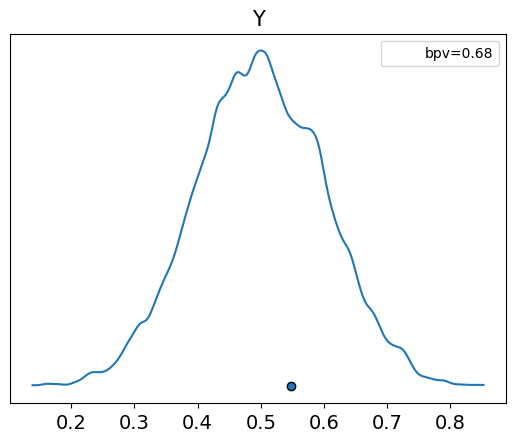

<Figure size 640x480 with 0 Axes>

In [ ]:
az.plot_bpv(iirt,
            kind = 't_stat', 
            t_stat = 'mean')
plt.show()
plt.clf()

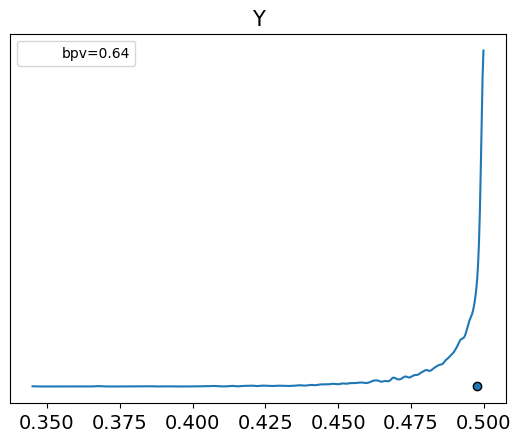

<Figure size 640x480 with 0 Axes>

In [ ]:
az.plot_bpv(iirt,
            kind = 't_stat', 
            t_stat = 'std')
plt.show()
plt.clf()

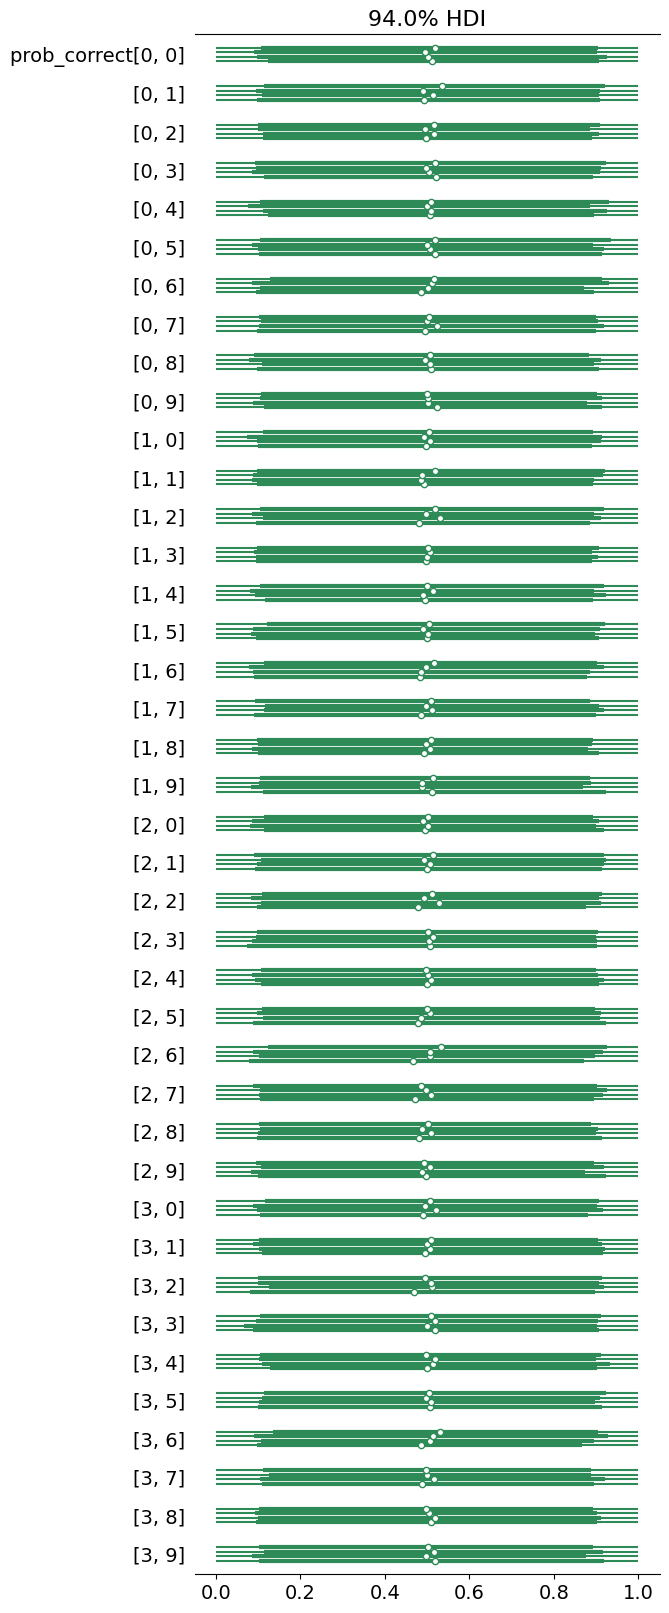

<Figure size 640x480 with 0 Axes>

In [11]:
az.plot_forest(iirt.posterior["prob_correct"].isel(prob_correct_dim_0 = slice(0, 4),
                                                    prob_correct_dim_1 = slice(None)
                                                    ),
               var_names = 'prob_correct',
               colors = jpcolor)
plt.show()
plt.clf()

In [12]:
# pandas dataframe for working with 
irtdf = irt_fit.draws_pd()
irtdf.head()

chain__  iter__  draw__       lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -92.490529       0.762796    0.425211          4.0   
1      1.0     2.0     2.0 -87.403046       0.908740    0.425211          3.0   
2      1.0     3.0     3.0 -90.815223       0.966500    0.425211          4.0   
3      1.0     4.0     4.0 -70.303899       0.956166    0.425211          3.0   
4      1.0     5.0     5.0 -78.259984       0.724374    0.425211          3.0   

   n_leapfrog__  divergent__   energy__  theta[1]  theta[2]  theta[3]  \
0          15.0          0.0  164.11251  0.740633  0.867703  1.237835   
1           7.0          0.0  164.03941 -0.797963 -1.237046  1.220463   
2          15.0          0.0  146.93022  0.699265  1.093180 -1.131382   
3           7.0          0.0  149.73050 -0.410484  0.962445  0.407969   
4           7.0          0.0  141.83797  0.181046 -0.454756  2.167065   

   theta[4]  theta[5]  theta[6]  theta[7]  theta[8]  theta[9]  theta[10]  \
0  0.687080 -0.816942 -0.103488 -0.488514 -0.443132  0.372218   1.356168   
1  1.252935  0.689990 -0.347022 -1.025776  1.094696  0.662958  -1.747421   
2 -1.177571 -0.868625  0.300464  1.280881 -1.055350 -0.329276   1.613034   
3  0.347325 -0.039532 -0.018476 -1.828378 -0.719942 -0.521767   2.213898   
4 -0.361271  1.267945  1.298547  0.671598  1.643578 -1.259143   1.109955   

   theta[11]  theta[12]  theta[13]  theta[14]  theta[15]  theta[16]  \
0  -0.103363  -2.194779   0.701648  -0.062859  -0.043509  -0.184426   
1   0.224351   0.965589   2.358434  -0.293542   0.962755   0.782963   
2  -0.119533  -0.968352  -2.359515  -0.089488  -1.031251  -1.088026   
3   0.563508  -0.153134   1.585568   0.226341  -0.484709   0.075160   
4  -0.614460   1.829061   0.491755  -0.767101  -0.792516  -1.095157   

   theta[17]  theta[18]  theta[19]  theta[20]  theta[21]  theta[22]  \
0   0.969168   1.537008   1.239116   1.169890  -0.806689   0.937073   
1  -2.136758   1.094192   0.666549  -0.671310   1.137443  -0.983129   
2   2.135783  -1.383684  -0.717378   1.101719  -0.988398   0.992281   
3  -0.253881   0.432775  -1.307329   0.710223  -0.875876  -0.401326   
4   0.302572  -1.525521  -1.891053   0.190608   0.754322   0.121795   

   theta[23]  theta[24]  theta[25]  theta[26]  theta[27]  theta[28]  \
0   0.186117  -0.348641   0.921698  -1.774758  -1.507313   1.379622   
1  -0.339151  -0.153972   0.420727  -0.735910   1.430239  -1.670082   
2   0.409378   0.142354  -0.252811   0.726752  -1.792944   1.785640   
3  -2.256520  -0.841851  -0.073196   1.252304   0.445030  -0.907318   
4   1.899934   0.923207  -0.108860   1.045843   1.365757  -0.352634   

   theta[29]  theta[30]  theta[31]  theta[32]  theta[33]  theta[34]  \
0   1.484874   0.705416   0.905728  -0.829601   1.018178  -0.999668   
1   0.122038  -0.118655  -0.601520  -0.769229   0.963045   0.567450   
2  -0.235257   0.400428   0.849737   0.725621  -0.967784  -0.530746   
3  -1.428472  -0.307909   0.904096   1.693702  -0.152997   1.509716   
4  -2.517882   1.080064   1.745782   1.162842  -0.653119   1.505214   

   theta[35]  theta[36]  theta[37]  theta[38]  theta[39]  theta[40]  \
0  -0.254841   1.710590   1.859514   0.303269  -0.235438   0.760480   
1  -1.548677  -0.657714   0.124802   1.019521   1.543492  -0.313396   
2   1.966110   0.750163  -0.180029  -0.974516  -1.482911   0.295469   
3   0.564544   0.974628   0.593542  -0.216461  -0.360870   1.315878   
4   1.317010   0.088942  -1.929122  -1.665207   1.067853   0.603641   

   theta[41]  theta[42]  theta[43]  theta[44]  theta[45]  theta[46]  \
0   1.304567  -0.649102  -1.272858   0.088745  -0.316775  -3.132171   
1   0.697883  -0.032317   0.626548  -0.897296   0.371355   0.901090   
2  -0.711638   0.068642  -0.620710   0.995032  -0.422389  -0.857923   
3   1.041820   0.277525   0.595556   0.152180   0.087269   0.169248   
4  -0.011434   0.186815  -0.744398   0.431041   0.705411   0.794856   

   theta[47]  theta[48]  theta[49]  theta[50]  theta[51]  

## Student Ability

$\theta$

In [13]:
def q_lower(x):
    return x.quantile(.025)
  
def q_upper(x):
    return x.quantile(.975)

In [ ]:
ability = irtdf.filter(regex = 'theta')
ability = (
  ability
  .agg(['mean', q_lower, q_upper])
)
ability = ability.reset_index().melt(id_vars = 'index')
ability['stu'] = ability['variable'].str.replace('theta[', '')
ability['stu'] = ability['stu'].str.replace(']', '')
ability = ability.drop(columns = 'variable')
ability = ability.rename(columns = {'value': 'theta'})

ability_wide = ability.pivot(index = 'stu', columns = 'index', values = 'theta')
ability_wide = ability_wide.reset_index()
ability_wide['stu'] = ability_wide['stu'].astype(int)
ability_wide = ability_wide.sort_values('stu')

/var/folders/dk/cmy022cd5r76h3m6psgj_yf40000gn/T/ipykernel_16588/3477104067.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


,variable,value
0,index,mean
1,index,q_lower
2,index,q_upper
3,theta[1],0.013554
4,theta[1],-1.89217
...,...,...
337,theta[112],-1.928791
338,theta[112],1.901312
339,theta[113],0.004832
340,theta[113],-1.991351


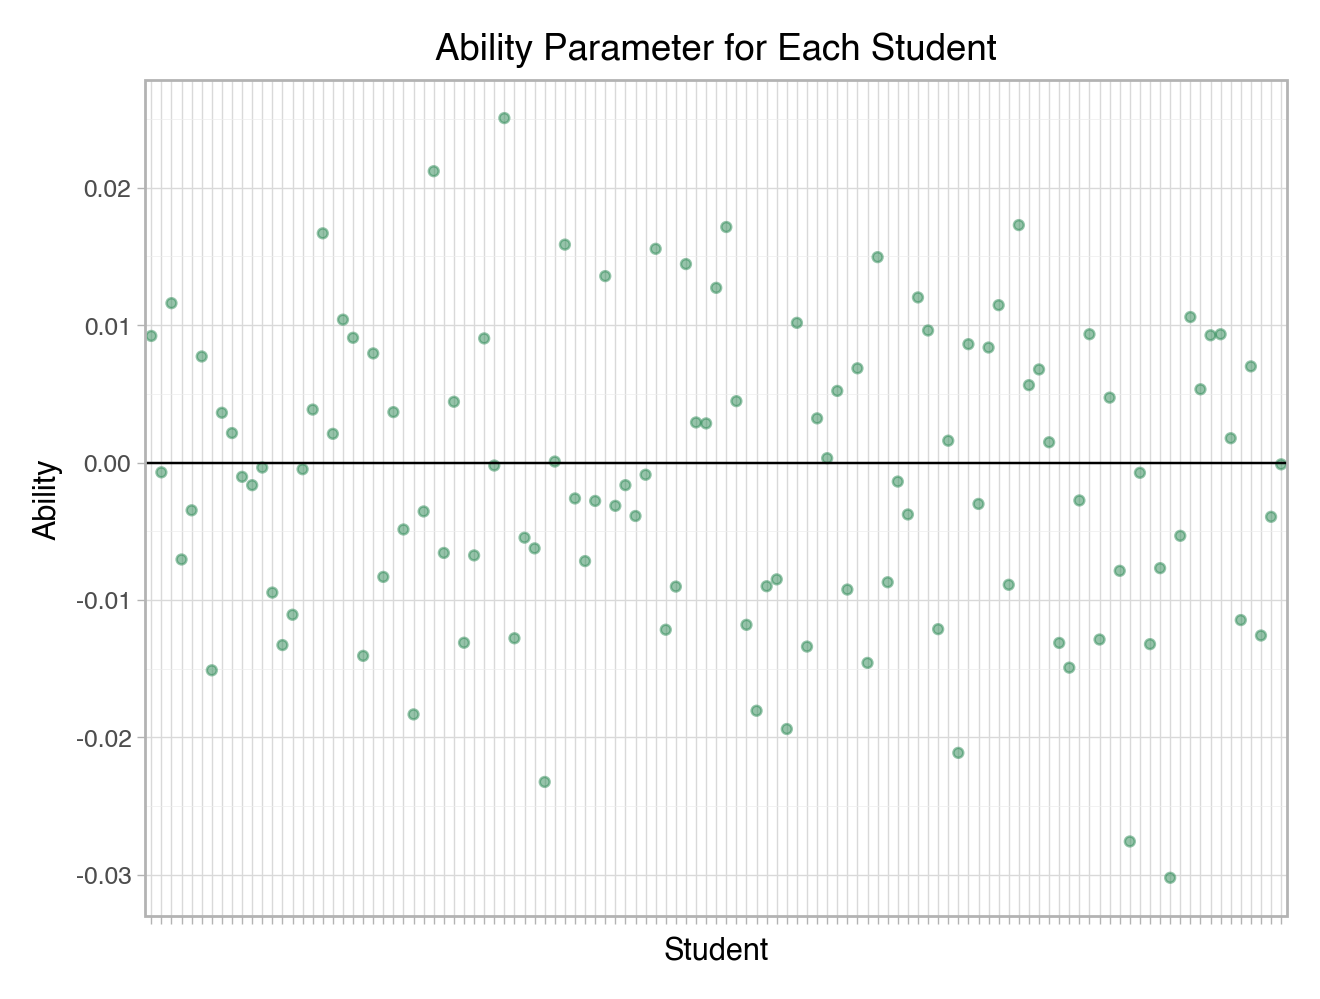

In [ ]:
pn.ggplot.show(
  pn.ggplot(ability_wide,
            pn.aes('stu',
                   'mean'))
  + pn.geom_point(alpha = .5,
                  color = jpcolor)
  + pn.geom_errorbar(pn.aes(ymin = 'q_lower',
                            ymax = 'q_upper'),
                     alpha = .3,
                     color = jpcolor)
  + pn.geom_hline(yintercept = 0,
                  color = 'black',
                  linetype = 'dashed')
  + pn.labs(title = 'Ability Parameter for Each Student',
            x = 'Student',
            y = 'Ability')
  + pn.theme(axis_text_x = pn.element_blank())
)

## Discrimination

a = discrimination (differentiate between individuals w/ different ability levels (theta))

high value = strong discrimination, low value = weak discrimination

negative = low theta individuals more likely to get responses correct

In [ ]:
dis = irtdf.filter(regex = '^a.*]$')
dis = (
  dis
  .agg(['mean', q_lower, q_upper])
)
dis = dis.reset_index().melt(id_vars = 'index')
dis['item'] = dis['variable'].str.replace('a[', '')
dis['item'] = dis['item'].str.replace(']', '')
dis = dis.drop(columns = 'variable')
dis = dis.rename(columns = {'value': 'discrimination'})
dis.head()

dis_wide = dis.pivot(index = 'item', columns = 'index', values = 'discrimination')
dis_wide = dis_wide.reset_index()
dis_wide['item'] = dis_wide['item'].astype(int)
dis_wide = dis_wide.sort_values('item')

,index,discrimination
0,1,2.719584
1,2,2.708332
2,3,2.726700
3,4,2.668173
4,5,2.694734


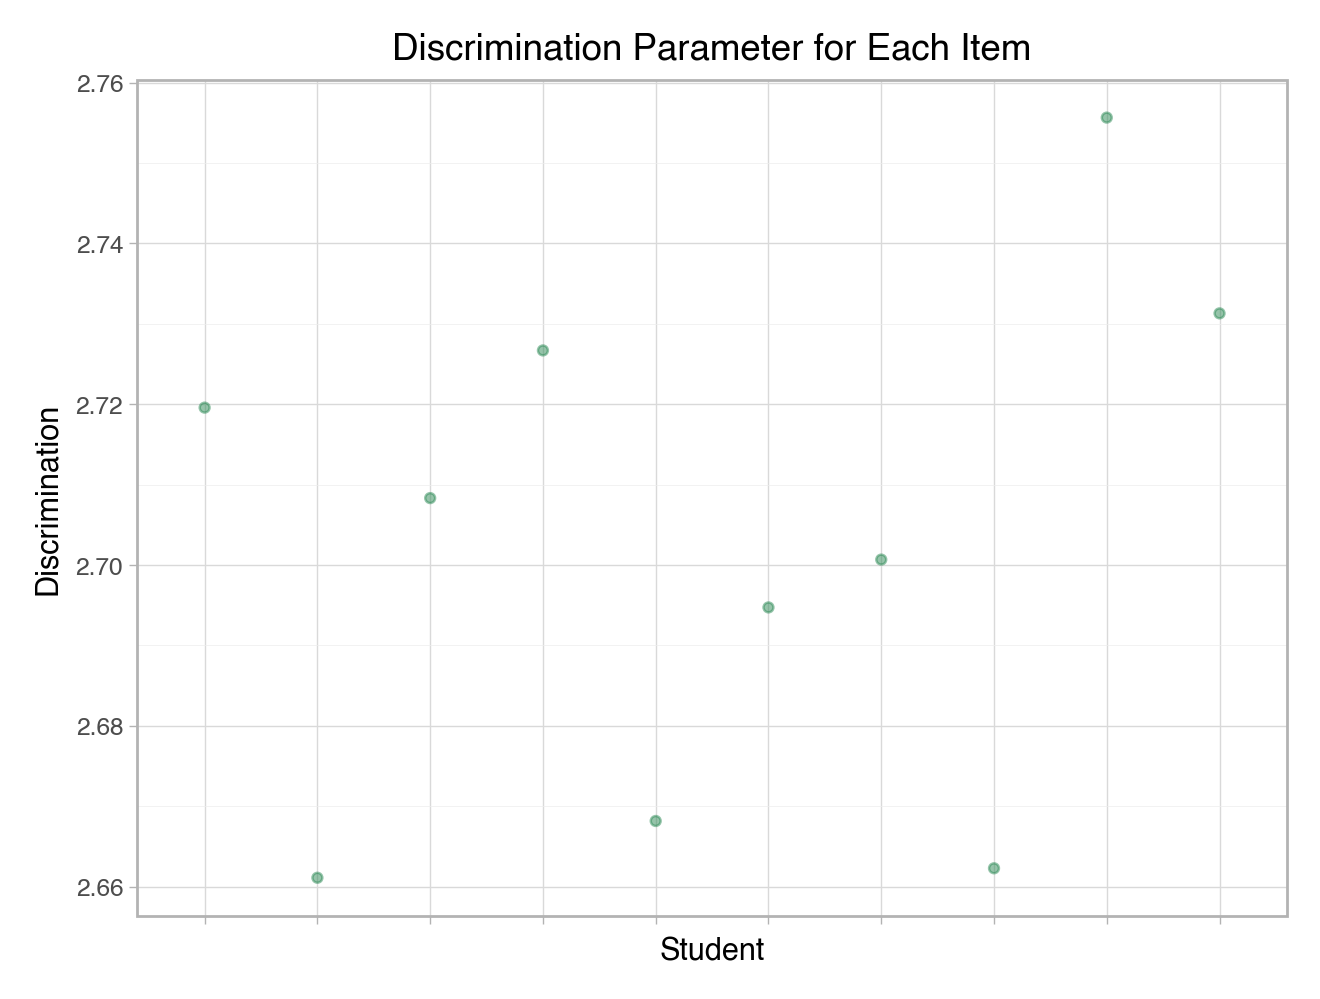

In [ ]:
pn.ggplot.show(
  pn.ggplot(dis_wide,
            pn.aes('item',
                   'mean'))
  + pn.geom_point(alpha = .5,
                  color = jpcolor)
  + pn.geom_errorbar(pn.aes(ymin = 'q_lower',
                            ymax = 'q_upper'),
                     alpha = .3,
                     color = jpcolor)
  # + pn.geom_hline(yintercept = 0,
  #                 color = 'black',
  #                 linetype = 'dashed')
  + pn.labs(title = 'Discrimination Parameter for Each Item',
            x = 'Item',
            y = 'Discrimination')
  + pn.theme(axis_text_x = pn.element_blank())
)

## Difficulty (2pl | 3pl model)

b = difficulty 

0 = average difficulty, 2+ = very hard, -2 = very easy

In [ ]:
diff = irtdf.filter(regex = '^b.*]$')
diff = (
  diff
  .agg(['mean', q_lower, q_upper])
)
diff = diff.reset_index().melt(id_vars = 'index')
diff['item'] = diff['variable'].str.replace('b[', '')
diff['item'] = diff['item'].str.replace(']', '')
diff = diff.drop(columns = 'variable')
diff = diff.rename(columns = {'value': 'difficulty'})
diff.head()

diff_wide = diff.pivot(index = 'item', columns = 'index', values = 'difficulty')
diff_wide = diff_wide.reset_index()
diff_wide['item'] = diff_wide['item'].astype(int)
diff_wide = diff_wide.sort_values('item')

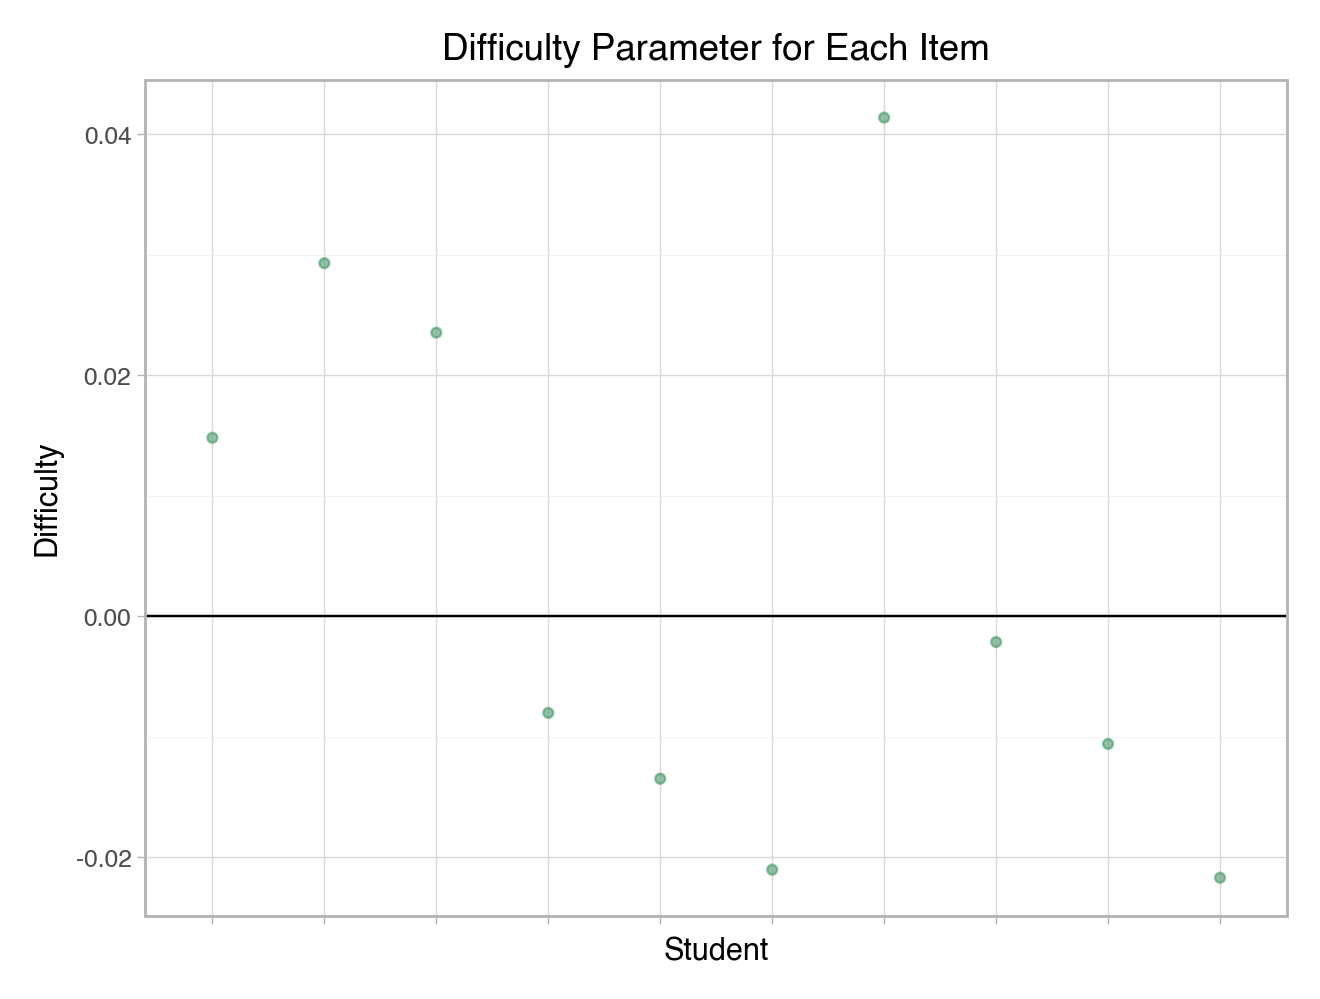

In [ ]:
pn.ggplot.show(
  pn.ggplot(diff_wide,
            pn.aes('item',
                   'mean'))
  + pn.geom_point(alpha = .5,
                  color = jpcolor)
  + pn.geom_errorbar(pn.aes(ymin = 'q_lower',
                            ymax = 'q_upper'),
                     alpha = .3,
                     color = jpcolor)
  # + pn.geom_hline(yintercept = 0,
  #                 color = 'black',
  #                 linetype = 'dashed')
  + pn.labs(title = 'Difficulty Parameter for Each Item',
            x = 'Item',
            y = 'Difficulty')
  + pn.theme(axis_text_x = pn.element_blank())
)

# Guessing (3pl model)

c = guessing

higher value = easy to guess

In [ ]:
guess = irtdf.filter(regex = '^c.*]$')
guess = (
  guess
  .agg(['mean', q_lower, q_upper])
)
guess = guess.reset_index().melt(id_vars = 'index')
guess['item'] = guess['variable'].str.replace('c[', '')
guess['item'] = guess['item'].str.replace(']', '')
guess = guess.drop(columns = 'variable')
guess = guess.rename(columns = {'value': 'difficulty'})
guess.head()

guess_wide = guess.pivot(index = 'item', columns = 'index', values = 'difficulty')
guess_wide = guess_wide.reset_index()
guess_wide['item'] = guess_wide['item'].astype(int)
guess_wide = guess_wide.sort_values('item')

In [ ]:
pn.ggplot.show(
  pn.ggplot(guess_wide,
            pn.aes('item',
                   'mean'))
  + pn.geom_point(alpha = .5,
                  color = jpcolor)
  + pn.geom_errorbar(pn.aes(ymin = 'q_lower',
                            ymax = 'q_upper'),
                     alpha = .3,
                     color = jpcolor)
  # + pn.geom_hline(yintercept = 0,
  #                 color = 'black',
  #                 linetype = 'dashed')
  + pn.labs(title = 'Difficulty Parameter for Each Item',
            x = 'Item',
            y = 'Difficulty')
  + pn.theme(axis_text_x = pn.element_blank())
)

# Comparison to Actual Response Data

Looking at posterior predictive probability (ppp) values 

.5 is the best marker

